In [1]:
!pip install transformers
!pip install gradio
!pip install timm
!pip install torchvision
!pip install ipywidgets

In [2]:
from transformers.utils import logging
logging.set_verbosity_error()

In [3]:
from transformers import pipeline

2024-05-22 21:29:18.967261: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [4]:
sam_pipe = pipeline("mask-generation",
    "Zigeng/SlimSAM-uniform-77")

In [5]:
from PIL import Image

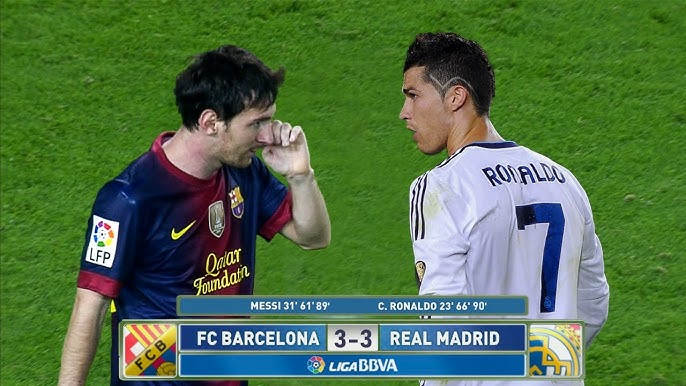

In [6]:
raw_image = Image.open('image_segmentation_test.jpg')
raw_image.resize((686, 386))

In [7]:
output = sam_pipe(raw_image, points_per_batch=32)

In [13]:
pip install ipynb

Note: you may need to restart the kernel to use updated packages.


In [14]:
from ipynb.fs.full.helper import show_pipe_masks_on_image

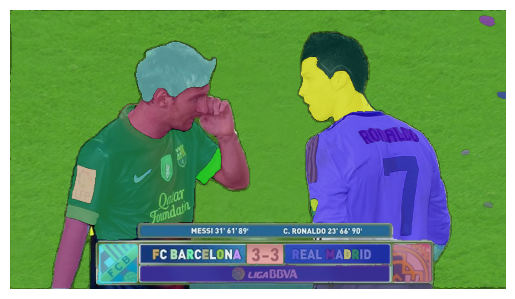

In [15]:
show_pipe_masks_on_image(raw_image, output)

In [16]:
from transformers import SamModel, SamProcessor

In [17]:
model = SamModel.from_pretrained(
    "Zigeng/SlimSAM-uniform-77")

processor = SamProcessor.from_pretrained(
    "Zigeng/SlimSAM-uniform-77")

In [18]:
model

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 168, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0): SamVisionLayer(
        (layer_norm1): LayerNorm((168,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=168, out_features=504, bias=True)
          (proj): Linear(in_features=168, out_features=168, bias=True)
        )
        (layer_norm2): LayerNorm((168,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=168, out_features=696, bias=True)
          (lin2): Linear(in_features=696, out_features=168, bias=True)
          (act): GELUActivation()
        )
      )
      (1): SamVisionLayer(
        (layer_norm1): LayerNorm((168,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(

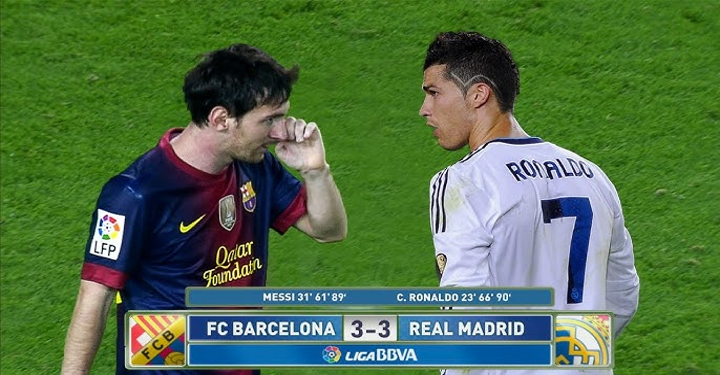

In [19]:
raw_image.resize((720, 375))

In [71]:
input_points = [[[1600, 700]]]

In [72]:
inputs = processor(raw_image,
                 input_points=input_points,
                 return_tensors="pt")

In [73]:
import torch

In [74]:
with torch.no_grad():
    outputs = model(**inputs)

In [75]:
predicted_masks = processor.image_processor.post_process_masks(
    outputs.pred_masks,
    inputs["original_sizes"],
    inputs["reshaped_input_sizes"]
)

In [76]:
len(predicted_masks)

1

In [77]:
predicted_mask = predicted_masks[0]
predicted_mask.shape

torch.Size([1, 3, 386, 686])

In [78]:
outputs.iou_scores

tensor([[[0.3038, 0.6460, 0.2918]]])

In [79]:
from ipynb.fs.full.helper import show_mask_on_image

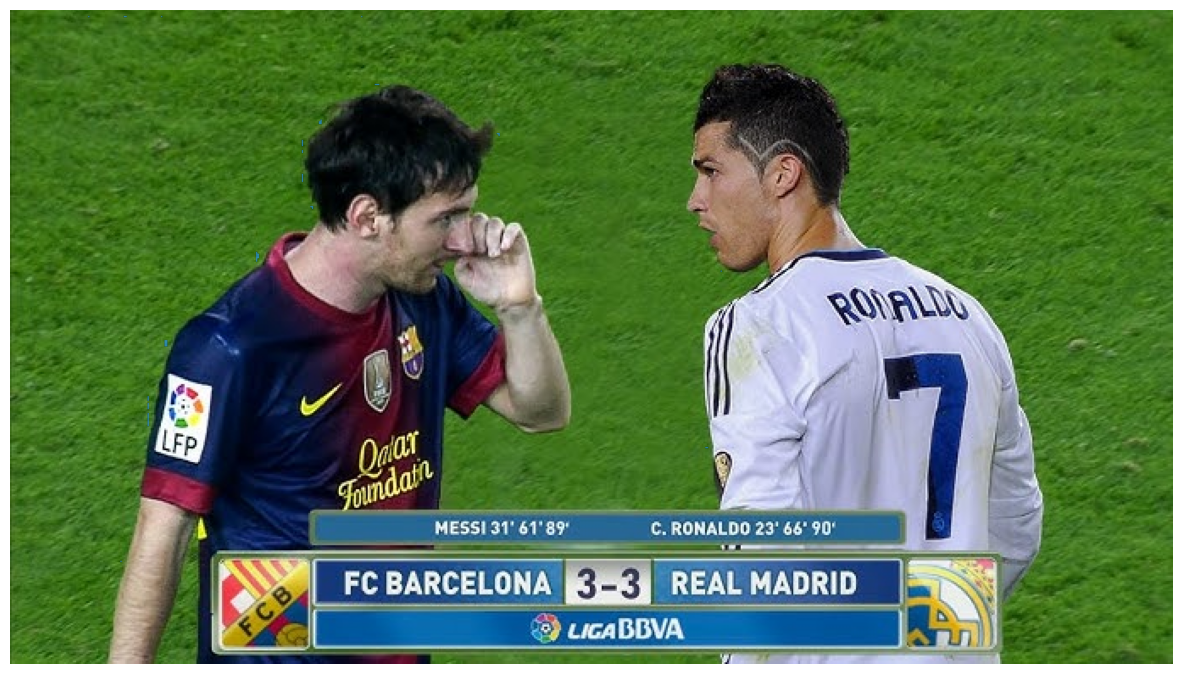

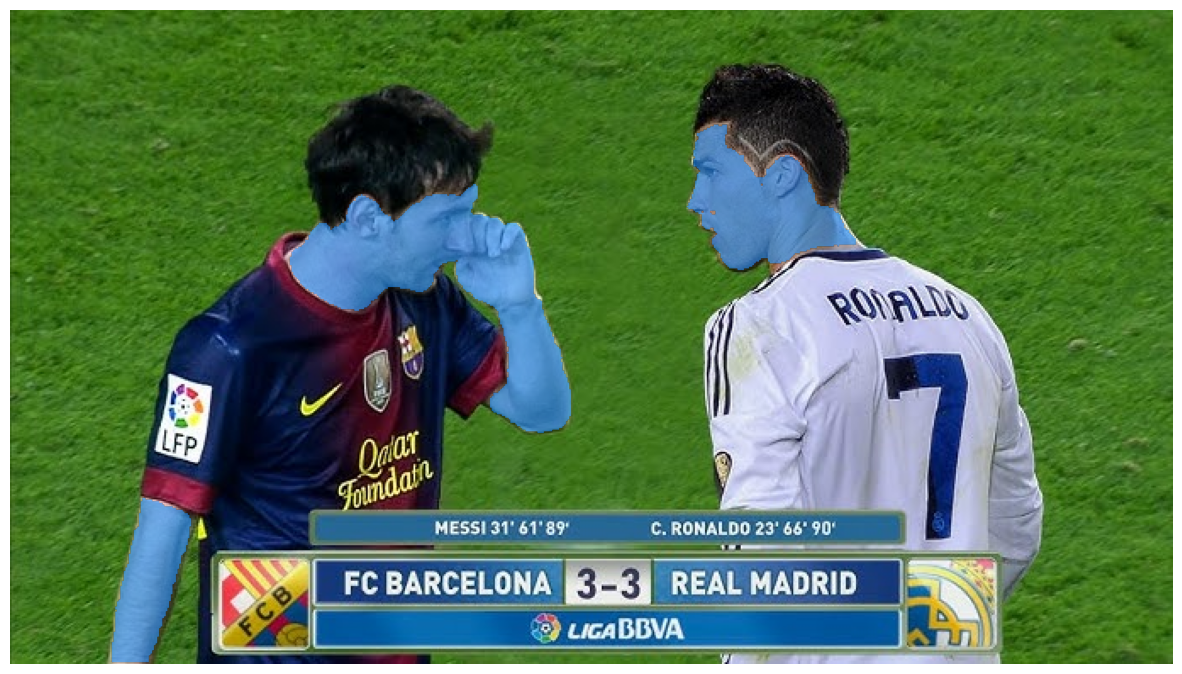

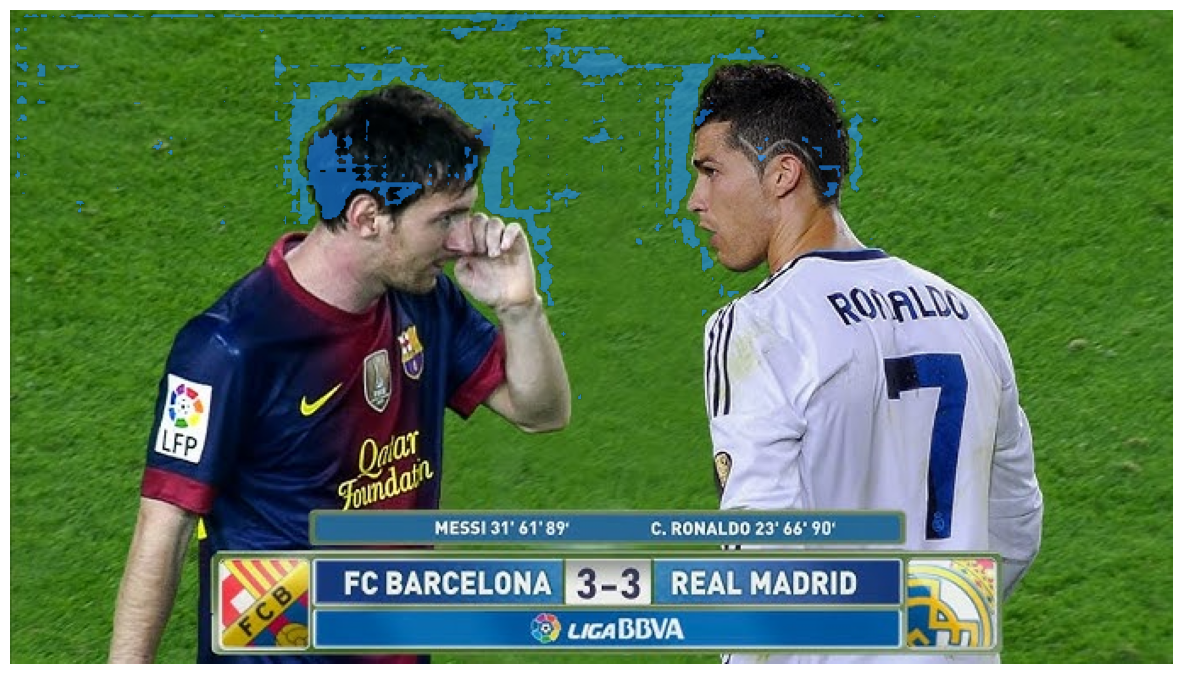

In [80]:
for i in range(3):
    show_mask_on_image(raw_image, predicted_mask[:, i])

In [81]:
depth_estimator = pipeline(task="depth-estimation",
                        model="Intel/dpt-hybrid-midas")

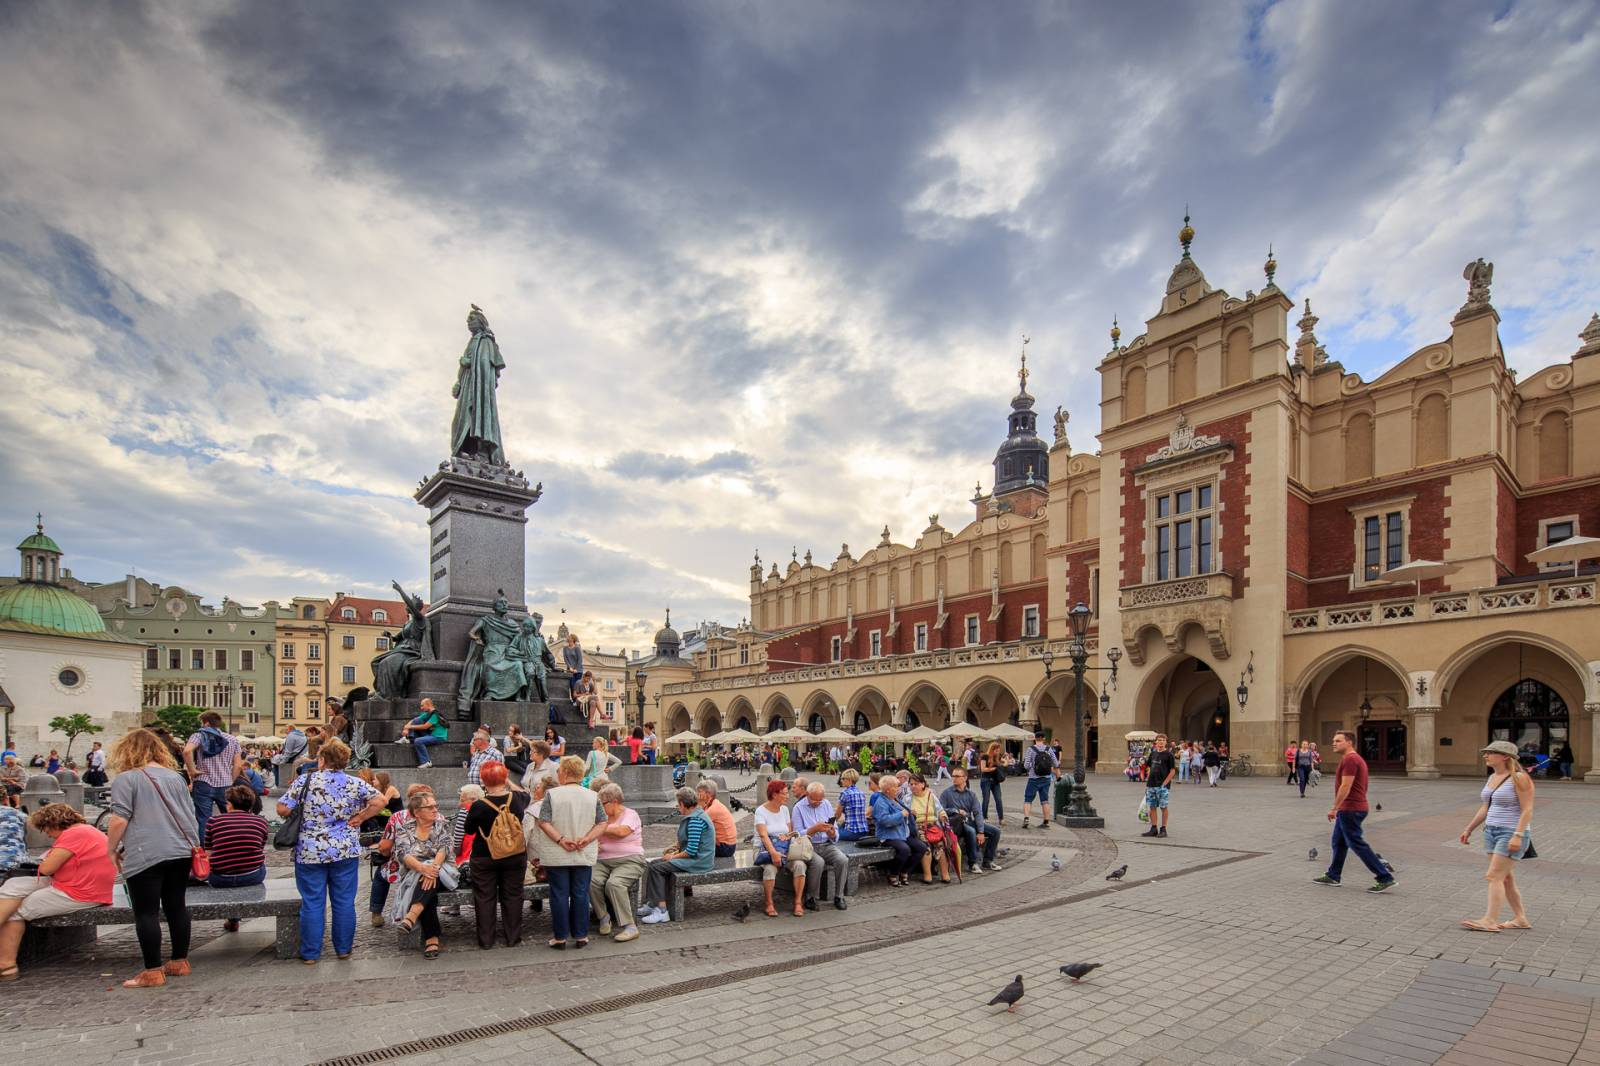

In [84]:
raw_image = Image.open('test_image2.jpg')
raw_image.resize((1600, 1066))

In [85]:
output = depth_estimator(raw_image)

In [86]:
output

{'predicted_depth': tensor([[[  27.4430,   26.7240,   25.2127,  ...,   76.6253,   76.9841,
             61.6937],
          [  25.9133,   24.0080,   23.7279,  ...,   77.6199,   78.9677,
             86.1030],
          [  26.0616,   24.2755,   23.4527,  ...,   77.3861,   77.6807,
             83.4715],
          ...,
          [3086.5522, 3094.1462, 3095.2249,  ..., 3256.8728, 3248.0862,
           3244.1189],
          [3116.0251, 3116.0769, 3119.2031,  ..., 3266.5867, 3272.5273,
           3258.9446],
          [3115.8289, 3131.3423, 3126.1313,  ..., 3292.0525, 3290.1699,
           3279.7732]]]),
 'depth': <PIL.Image.Image image mode=L size=1600x1066>}

In [87]:
output["predicted_depth"].shape

torch.Size([1, 384, 384])

In [88]:
output["predicted_depth"].unsqueeze(1).shape

torch.Size([1, 1, 384, 384])

In [89]:
prediction = torch.nn.functional.interpolate(
    output["predicted_depth"].unsqueeze(1),
    size=raw_image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

In [90]:
prediction.shape

torch.Size([1, 1, 1066, 1600])

In [91]:
raw_image.size[::-1],

((1066, 1600),)

In [92]:
prediction

tensor([[[[  27.6771,   27.6584,   27.5757,  ...,   60.4447,   57.6043,
             57.0372],
          [  27.4776,   27.4535,   27.3426,  ...,   63.6629,   61.3318,
             60.8666],
          [  26.9680,   26.9301,   26.7470,  ...,   71.9064,   70.8665,
             70.6599],
          ...,
          [3117.0498, 3117.3359, 3118.7769,  ..., 3273.7754, 3271.7917,
           3271.3987],
          [3114.2241, 3114.7029, 3117.1326,  ..., 3279.9871, 3278.3198,
           3277.9849],
          [3113.9194, 3114.4692, 3117.2598,  ..., 3282.8904, 3281.3054,
           3280.9851]]]])

In [93]:
import numpy as np 

In [94]:
output = prediction.squeeze().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

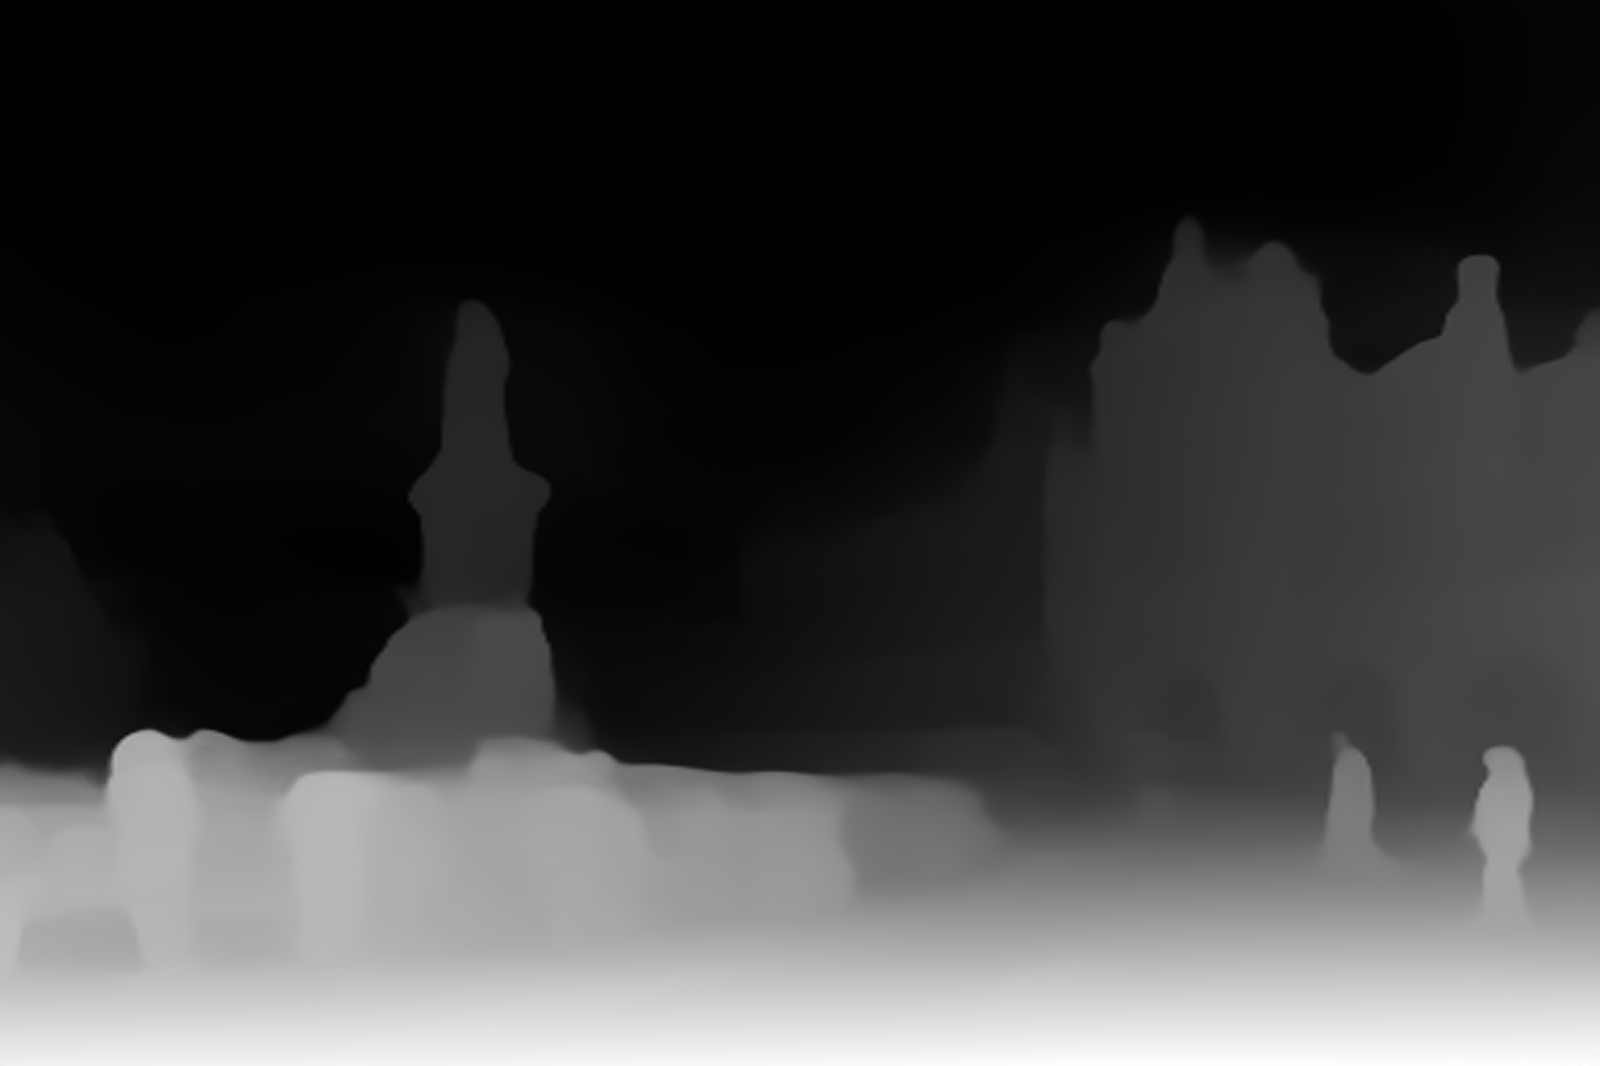

In [95]:
depth

In [96]:
import os
import gradio as gr
from transformers import pipeline

In [97]:
def launch(input_image):
    out = depth_estimator(input_image)

    # resize the prediction
    prediction = torch.nn.functional.interpolate(
        out["predicted_depth"].unsqueeze(1),
        size=input_image.size[::-1],
        mode="bicubic",
        align_corners=False,
    )

    # normalize the prediction
    output = prediction.squeeze().numpy()
    formatted = (output * 255 / np.max(output)).astype("uint8")
    depth = Image.fromarray(formatted)
    return depth

In [98]:
iface = gr.Interface(launch, 
                     inputs=gr.Image(type='pil'), 
                     outputs=gr.Image(type='pil'))

IMPORTANT: You are using gradio version 3.34.0, however version 4.29.0 is available, please upgrade.
--------


In [99]:
iface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://c96f05e2faf9c3c3cc.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [100]:
iface.close()

Closing server running on port: 7860
